In [1]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

import csv
import umap
import scanpy as sc

In [2]:
import h5py
from scipy.sparse import csr_matrix

def load_data(dataset,gene_percent_cells=0.01,peak_percent_cells=0.001,include_h5=True,
              preprocess=True,sampling=None,distance=1000000):
    
    data_dir = '/data/cb/alexwu/mm_finemap/datasets/{}'.format(dataset)

    if sampling == 'geosketch':
        rna_adata = sc.read(os.path.join(data_dir,'{}.rna.sketch.h5ad'.format(dataset)))
        atac_adata = sc.read(os.path.join(data_dir,'{}.atac.sketch.h5ad'.format(dataset)))
    elif sampling == 'uniform':
        rna_adata = sc.read(os.path.join(data_dir,'{}.rna.uniform.h5ad'.format(dataset)))
        atac_adata = sc.read(os.path.join(data_dir,'{}.atac.uniform.h5ad'.format(dataset)))        
    else:
        rna_adata = sc.read(os.path.join(data_dir,'{}.rna.h5ad'.format(dataset)))
        atac_adata = sc.read(os.path.join(data_dir,'{}.atac.h5ad'.format(dataset)))

    if dataset == 'sci_car':
        data_dir = '/data/cb/alexwu/mm_finemap/data/sci_car'
        adata = sc.read(os.path.join(data_dir,'adata-hs.h5ad'))

        atac_adata.var['chr_no'] = ['chr' + n for n in atac_adata.var['chr_no']]
        atac_adata.var['start'] = adata.uns['atac.var'][:,2].astype(int)
        atac_adata.var['end'] = adata.uns['atac.var'][:,3].astype(int)

    if preprocess:
        # scale by maximum 
        # (rna already normalized by library size + log-transformed)
        X_max = rna_adata.X.max(0).toarray().squeeze()
        X_max[X_max == 0] = 1
        rna_adata.X = csr_matrix(rna_adata.X / X_max)

        # atac: normalize library size + log transformation
        sc.pp.normalize_total(atac_adata,target_sum=1e4)
        sc.pp.log1p(atac_adata)

    if include_h5:
        data_dir = '/data/cb/alexwu/mm_finemap/datasets/{}'.format(dataset)
        with h5py.File(os.path.join(data_dir,'dataset.h5'),'r') as f:
            print(f.keys())
            data_df = pd.DataFrame()
            for k in ['chr_no','eqtl','hic','dist','atac_id','gene','corr','group_corr','gene_percent_cells',
                      'peak_percent_cells','hg38tohg19_eqtl','eqtl.new','corr_bin','group_corr_bin',
                      'hic_0hr','hic_1hr','hic_4hr','eqtl.q','hic_4hr.expectedBL','eqtl.all','hic.new2',
                      'hic.100kb','ABC.score']: #,
#                      'hic_0hr.expectedBL','hic_1hr.expectedBL','hic_4hr.expectedBL.new','hic_0hr.expectedBL.new',
#                      'hic_4hr.expectedBL.new2','hic_12hr.expectedBL','hic_4hr.expectedBL.full']:
                if k in f.keys():
                    data_df[k] = f[k][:]

        small_df = data_df[abs(data_df['dist']) < distance]

        # small_df = small_df[~np.isnan(small_df['group_corr'])]
        small_df = small_df[small_df['gene_percent_cells'] > gene_percent_cells]
        small_df = small_df[small_df['peak_percent_cells'] > peak_percent_cells]

        small_df.index = [(atac_idx,gene) for atac_idx,gene in small_df[['atac_id','gene']].values]
    
        return rna_adata,atac_adata,small_df

    else:
        
        return rna_adata,atac_adata

In [3]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

def get_results(dataset,method,n_layers=None,n_neighbors=None,mode=None,sketch=False,trial_no=None,new=True):
    
    data_dir = '/data/cb/alexwu/mm_finemap/results/tests_nn/{}'.format(dataset)
    
    if method == 'graph':
        trial_str = 'new2' if trial_no == 0 else 'trial{}'.format(trial_no)
        if sketch:
            file_name = 'graph.sketch.{}.all.max_scale.mseloss.{}layers.nn{}.{}.p.txt'.format(trial_str,n_layers,n_neighbors,mode)
        else:
            file_name = 'graph.{}.all.max_scale.mseloss.{}layers.nn{}.{}.p.txt'.format(trial_str,n_layers,n_neighbors,mode)
    elif method == 'granger':
        if sketch:
            file_name = 'baseline.bin.sketch.bin.results.txt'
        else:
            file_name = 'baseline.bin.bin.results.txt'
    elif method == 'graph.base':
        if sketch:
            file_name = 'graph.base.sketch.new.{}layers.nn{}.{}.txt'.format(n_layers,n_neighbors,mode)
        else:
            file_name = 'graph.base.new.{}layers.nn{}.{}.txt'.format(n_layers,n_neighbors,mode)
            
    elif method == 'gvar':
        if sketch:
            file_name = 'gvar.bin.sketch.trial{}.results.txt'.format(trial_no)
        else:
            file_name = 'gvar.bin.trial{}.bin.results.txt'.format(trial_no)

    elif method == 'GVAR':
        if sketch:
            file_name = 'GVAR.bin.sketch.trial{}.bin.results.txt'.format(trial_no)
        else:
            file_name = 'GVAR.bin.trial{}.bin.results.txt'.format(trial_no)
            
    scores = pd.read_csv(os.path.join(data_dir,file_name),header=None).values
    if scores.shape[1] > 1:
        scores = scores[:,2]
    
    if (method == 'graph' and mode == 'lr') or method == 'gvar':
        return scores
    else:
        scores[scores == 0] = 10**-100
        scores = -np.log10(scores)
        return scores

def print_results(eval_df,method_list,feature,thresh,direction,metric='auprc'):
    
    if direction == 'less':
        y_true = eval_df[feature].values <= thresh
    elif direction == 'greater':
        y_true = eval_df[feature].values >= thresh

#     print('\nBASELINE:',y_true.mean(),'----------\n')

    data_dict = {'method': [], metric: []}
    for method in method_list:
        scores = eval_df[method].values
#         if 'corr' in method:
#             scores = abs(scores)
#         elif 'dist' in method:
#             scores = -abs(scores)
                
        if metric == 'auprc':
            value = average_precision_score(y_true,scores)
        elif metric == 'auroc':
            value = roc_auc_score(y_true,scores)
#         elif metric == 'f1':
#             scores = (scores > np.percentile(scores,99)).astype(int)
#             value = f1_score(y_true,scores)
            
        auprc = average_precision_score(y_true,scores)
        data_dict['method'].append(method)
        data_dict[metric].append(value)

    results_df = pd.DataFrame(data_dict)
    results_df['trial_no'] = [int(n.split('trial')[1]) if 'trial' in n else 0 for n in results_df['method']]
    results_df['method'] = [n.split('.trial')[0] for n in results_df['method']]
    
    return results_df

def get_precision_recall(eval_df,method,feature,percentile,direction):
    
    scores_list = []
    y_true_list = []
    for chr_no in sorted(list(set(eval_df['chr_no'].values))):
        
        chr_df = eval_df[eval_df['chr_no'] == chr_no]

        thresh = np.percentile(chr_df[feature].values,percentile)
        
        if direction == 'less':
            y_true = abs(chr_df[feature].values) <= thresh
        elif direction == 'greater':
            y_true = abs(chr_df[feature].values) >= thresh
            
        y_true_list.extend(y_true.astype(int).tolist())
        scores_list.extend(chr_df[method].values.tolist())
    
    y_true = np.array(y_true_list)
    
    scores = np.array(scores_list)
    if 'corr' in method:
        scores = abs(scores)
    elif 'dist' in method:
        scores = -abs(scores)

    precision, recall, thresholds = precision_recall_curve(y_true,scores)
    return precision, recall, thresholds

In [19]:
import math

def round_sigfigs(number,significant_digits=3):
    return round(number, significant_digits - int(math.floor(math.log10(abs(number)))) - 1)

def num_sigfigs(number):
    return len(str(number).split('.')[1].strip('0'))
    
def create_plot(results_df,metric):
    
    ax = sns.barplot(x='method',y=metric,hue='method',data=results_df,capsize=0.2,dodge=False,ci="sd")

    sns.stripplot(x='method',y=metric,hue='method',data=results_df,
                  ax=ax,color="black",size=3,alpha=0.8)

    handles, labels = ax.get_legend_handles_labels()
    plt.legend(handles[results_df["method"].nunique():],labels[results_df["method"].nunique():],
               bbox_to_anchor=(1,1),fontsize=16,frameon=False,handlelength=0.8)
    sns.despine()

    plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off

    plt.ylim(0,results_df[metric].max()*1.02)
    plt.xlabel('',fontsize=16)
    plt.ylabel(metric.upper(),fontsize=16)
    plt.yticks(fontsize=14)
    plt.xticks(rotation=90)
    
    return ax
    

In [5]:
from sklearn.feature_extraction.text import TfidfTransformer
from schema import SchemaQP
from scipy.stats import spearmanr
from collections import Counter

def preprocess(rna_adata,atac_adata):
    
    rna_adata.obs['n_counts'] = rna_adata.X.sum(1).astype(int)
    atac_adata.obs['n_counts'] = atac_adata.X.sum(1).astype(int)

    sc.pp.normalize_total(rna_adata,target_sum=1e5)
    sc.pp.log1p(rna_adata)
    
    rna_adata.var['gene_percent_cells'] = (rna_adata.X != 0).toarray().squeeze().mean(0)
    atac_adata.var['peak_percent_cells'] = (atac_adata.X != 0).toarray().squeeze().mean(0)

    # for genes represented via multiple transcripts, retain gene represented in most # of cells
    counts = Counter(rna_adata.var['symbol'].values)

    inds2keep = list(range(rna_adata.shape[1]))

    for gene,v in counts.items():
        if v > 1:
            inds = np.where(rna_adata.var['symbol'] == gene)[0]
            max_ind = inds[np.argmax(rna_adata.var.iloc[inds]['gene_percent_cells'].values)]
            for i in inds:
                if i != max_ind:
                    inds2keep.remove(i)

    rna_adata = rna_adata[:,inds2keep].copy()
    rna_adata.var.index = rna_adata.var['symbol'].values

    # remove genes,peaks in unlocalized sequences
    gene_inds2keep = [i for i,n in enumerate(rna_adata.var['chr_no'].values) if 'chr' in str(n)]
    atac_inds2keep = [i for i,n in enumerate(atac_adata.var['chr_no'].values) if 'chr' in str(n)]

    rna_adata = rna_adata[:,gene_inds2keep]
    atac_adata = atac_adata[:,atac_inds2keep]

    atac_adata.var.index = list(map(str,range(atac_adata.shape[1])))
    
    return rna_adata,atac_adata

def schema_representations(rna_adata,atac_adata,schema_reference='rna',other_modalities=None):

    # LEARN JOINT REPRESENTATIONS
    rna_adata_copy = rna_adata.copy()
    atac_adata_copy = atac_adata.copy()

    sc.pp.filter_genes(rna_adata_copy,min_cells=int(0.001*rna_adata.shape[0]))
    sc.pp.filter_genes(atac_adata_copy,min_cells=int(0.001*rna_adata.shape[0]))

    sc.pp.highly_variable_genes(rna_adata_copy,n_top_genes=2000)
    rna_adata_copy = rna_adata_copy[:,rna_adata_copy.var['highly_variable']]
    sc.pp.scale(rna_adata_copy)    
    
    tfidf = TfidfTransformer()
    idf = tfidf.fit_transform(atac_adata_copy.X)

    atac_adata_copy.X = idf

    sc.tl.pca(rna_adata_copy,n_comps=50)
    sc.tl.pca(atac_adata_copy,n_comps=50)

    rna_adata.obsm['X_pca'] = rna_adata_copy.obsm['X_pca']
    atac_adata.obsm['X_pca'] = atac_adata_copy.obsm['X_pca']

    atac_pca_inds2keep = []
    rna_pca_inds2keep = []
    for i in range(50):
        rho,p = spearmanr(atac_adata_copy.obsm['X_pca'][:,i],atac_adata_copy.obs['n_counts'])
        if rho < 0.9:
            atac_pca_inds2keep.append(i)

        rho,p = spearmanr(rna_adata_copy.obsm['X_pca'][:,i],rna_adata_copy.obs['n_counts'])
        if rho < 0.9:
            rna_pca_inds2keep.append(i)
            
    n_components = 50
    model = SchemaQP(0.99,params = {"decomposition_model": "pca", "num_top_components": n_components},\
                    mode = 'scale')

    if schema_reference == 'rna':
        secondary_modalities = [atac_adata.obsm['X_pca'][:,atac_pca_inds2keep]]
        if other_modalities:
            secondary_modalities.extend(other_modalities)
            
        W = model.fit_transform(rna_adata.obsm['X_pca'][:,rna_pca_inds2keep], # primary dataset
                                   secondary_modalities, # just one secondary dataset
                                   ['feature_vector'], # has labels, i.e., is a categorical datatype
                                   [1]
                                  )
        
    elif schema_reference == 'atac':
        secondary_modalities = [rna_adata.obsm['X_pca'][:,rna_pca_inds2keep]]
        if other_modalities:
            secondary_modalities.extend(other_modalities)
            
        W = model.fit_transform(atac_adata.obsm['X_pca'][:,atac_pca_inds2keep], # primary dataset
                                   secondary_modalities, # just one secondary dataset
                                   ['feature_vector'], # has labels, i.e., is a categorical datatype
                                   [1]
                                  )

    rna_adata.obsm['X_schema'] = W
    atac_adata.obsm['X_schema'] = W
    
def set_dpt_root(rna_adata,start_marker_gene):
    
    rna_adata.uns['iroot'] = np.argsort(-rna_adata[:,start_marker_gene].X.toarray().squeeze())[0]

In [6]:
# from geosketch import gs

# def apply_geosketch(dataset,rna_adata,atac_adata,start_marker_gene,N=5000):
    
#     data_dir = '/data/cb/alexwu/mm_finemap/datasets/{}'.format(dataset)

#     sketch_index = gs(rna_adata.obsm['X_schema'], N, replace=False)
    
#     rna_adata = rna_adata[sketch_index]
#     atac_adata = atac_adata[sketch_index]

#     rna_adata.uns['iroot'] = np.argsort(-rna_adata[:,start_marker_gene].X.toarray().squeeze())[0]

#     atac_adata.write_h5ad(os.path.join(data_dir,'{}.atac.sketch.h5ad'.format(dataset)))
#     rna_adata.write_h5ad(os.path.join(data_dir,'{}.rna.sketch.h5ad'.format(dataset)))

# def apply_uniform_sampling(dataset,rna_adata,atac_adata,start_marker_gene,N=5000,seed=1):
    
#     np.random.seed(seed)
    
#     data_dir = '/data/cb/alexwu/mm_finemap/datasets/{}'.format(dataset)
#     if not os.path.exists(data_dir):
#         os.mkdir(data_dir)

#     sketch_index = np.random.choice(range(rna_adata.shape[0]),size=N,replace=False)
    
#     rna_adata_sample = rna_adata[sketch_index].copy()
#     atac_adata_sample = atac_adata[sketch_index].copy()

#     rna_adata_sample.uns['iroot'] = np.argsort(-rna_adata_sample[:,start_marker_gene].X.toarray().squeeze())[0]

#     atac_adata_sample.write_h5ad(os.path.join(data_dir,'{}.atac.uniform.h5ad'.format(dataset)))
#     rna_adata_sample.write_h5ad(os.path.join(data_dir,'{}.rna.uniform.h5ad'.format(dataset)))




In [7]:
def calculate_correlations(data_df,rna_adata,atac_adata,corr_key):
    
    if 'atac_idx' in data_df.keys() and 'atac_id' not in data_df.keys():
        data_df['atac_id'] = data_df['atac_idx'].values
        
    corr_dict = {}
    for chr_no in sorted(list(set(data_df['chr_no'].values))):
        print(chr_no)
        filtered_data_df = data_df[data_df['chr_no'] == chr_no]

        gene_inds = sorted(list(set(filtered_data_df['gene'].values)))
        atac_inds = list(map(str,sorted(list(set(filtered_data_df['atac_id'].values.astype(int))))))

        filtered_rna_X = rna_adata[:,gene_inds].X.toarray()
        filtered_atac_X = atac_adata[:,atac_inds].X.toarray()

        rho = corr2_coeff(filtered_rna_X.T,filtered_atac_X.T)
        df = pd.DataFrame(rho,index=gene_inds,columns=atac_inds)

        for gene,atac_idx in filtered_data_df[['gene','atac_id']].values:
            corr_dict[(gene,atac_idx)] = df.loc[gene,str(atac_idx)]
            
    corr_list = []
    for gene,atac_idx in data_df[['gene','atac_id']].values:
        corr_list.append(corr_dict[(gene,atac_idx)])

    data_df[corr_key] = corr_list

    return data_df

def create_metacells(rna_adata,atac_adata):
    
    group_rna_X = []
    group_atac_X = []
    rna_X = rna_adata.X.toarray()
    rna_X = (((np.exp(rna_X)-1)/1e5).T*rna_adata.obs['n_counts'].values).T # raw counts

    for i in range(rna_adata.shape[0]):
        inds = np.nonzero(rna_adata.obsp['distances'][i])[1]
        inds = np.array(list(inds) + [i])
        group_rna_X.append(rna_X[inds].sum(0))
        group_atac_X.append(atac_adata[inds].X.sum(0))

        if i % 100 == 0:
            print(i)

    group_rna_X = np.array(group_rna_X).squeeze()
    group_atac_X = np.array(group_atac_X).squeeze()
    
    group_rna_adata = rna_adata.copy()
    group_atac_adata = atac_adata.copy()

    group_rna_adata.X = group_rna_X #.copy()
    group_atac_adata.X = group_atac_X #.copy()
    
    sc.pp.normalize_total(group_rna_adata,target_sum=1e5)
    sc.pp.log1p(group_rna_adata)

    sc.pp.normalize_total(group_atac_adata,target_sum=1e4)
    sc.pp.log1p(group_atac_adata)
    
    return group_rna_adata,group_atac_adata

def perform_correlation_calculations(data_df,rna_adata,atac_adata,dataset,mode):
    
    rna_adata_copy = rna_adata.copy()
    atac_adata_copy = atac_adata.copy()
    
    if mode == 'corr':
        sc.pp.normalize_total(atac_adata_copy,target_sum=1e4)
        sc.pp.log1p(atac_adata_copy)
        
    elif mode == 'group_corr':
        sc.pp.neighbors(rna_adata_copy,use_rep='X_schema',n_neighbors=50)
        rna_adata_copy,atac_adata_copy = create_metacells(rna_adata_copy,atac_adata_copy)

    corr_key = mode
    data_df = calculate_correlations(data_df,rna_adata_copy,atac_adata_copy,corr_key)

    save_dir = '/data/cb/alexwu/mm_finemap/datasets/{}'.format(dataset)

    with h5py.File(os.path.join(save_dir,'dataset.h5'),'a') as f:
        if corr_key in f.keys():
            del f[corr_key]
        f.create_dataset(corr_key,data=data_df[corr_key].values,dtype=float)

In [8]:
def calculate_gene_peak_percent_cells(data_df,rna_adata,atac_adata,dataset):
    gene_percent_cells = {g: percent for g,percent \
                          in zip(*[rna_adata.var.index.values,np.array((rna_adata.X != 0).mean(0)).squeeze()])}
    peak_percent_cells = {atac_idx: percent for atac_idx,percent \
                          in zip(*[atac_adata.var.index.values,np.array((atac_adata.X != 0).mean(0)).squeeze()])}

    atac_percent = []
    rna_percent = []
    for gene,atac_idx in data_df[['gene','atac_id']].values:
        atac_percent.append(peak_percent_cells[str(atac_idx)])
        rna_percent.append(gene_percent_cells[gene])

    data_df['gene_percent_cells'] = rna_percent
    data_df['peak_percent_cells'] = atac_percent

    import h5py

    save_dir = '/data/cb/alexwu/mm_finemap/datasets/{}'.format(dataset)

    with h5py.File(os.path.join(save_dir,'dataset.h5'),'a') as f:
        for key in ['gene_percent_cells','peak_percent_cells']:
            if k in f.keys():
                del f[key]
            f.create_dataset(key,data=data_df[key].values,dtype=float)

In [9]:
def write_rna_atac_indices(dataset,gene_percent_cells=0.01,peak_percent_cells=0.001,dist=1000000):

    data_dir = '/data/cb/alexwu/mm_finemap/datasets/{}'.format(dataset)
    with h5py.File(os.path.join(data_dir,'dataset.h5'),'r') as f:
        data_df = pd.DataFrame()
        for k in ['atac_id','gene','dist','gene_percent_cells','peak_percent_cells']:
            if k in f.keys():
                data_df[k] = f[k][:]

    small_df = data_df[abs(data_df['dist']) < dist]

    # small_df = small_df[~np.isnan(small_df['group_corr'])]
    small_df = small_df[small_df['gene_percent_cells'] > gene_percent_cells]
    small_df = small_df[small_df['peak_percent_cells'] > peak_percent_cells]

    print(small_df.shape)

    rna_adata = sc.read(os.path.join(data_dir,'{}.rna.h5ad'.format(dataset)))
    atac_adata = sc.read(os.path.join(data_dir,'{}.atac.h5ad'.format(dataset)))

    gene_idx_dict = {g:i for i,g in enumerate(rna_adata.var.index.values)}

    data_dir = '/data/cb/alexwu/mm_finemap/datasets/{}'.format(dataset)

    gene_idx = np.array([gene_idx_dict[g] for g in small_df['gene'].values])
    np.savetxt(os.path.join(data_dir,'atac_idx.txt'),small_df['atac_id'].values,fmt='%i')
    np.savetxt(os.path.join(data_dir,'rna_idx.txt'),gene_idx,fmt='%i')

In [10]:
def corr2_coeff(A, B):
    # Rowwise mean of input arrays & subtract from input arrays themeselves
    A_mA = A - A.mean(1)[:, None]
    B_mB = B - B.mean(1)[:, None]

    # Sum of squares across rows
    ssA = (A_mA**2).sum(1)
    ssB = (B_mB**2).sum(1)

    # Finally get corr coeff
    return np.dot(A_mA, B_mB.T) / np.sqrt(np.dot(ssA[:, None],ssB[None]))

In [11]:
from scipy.stats import rankdata

def load_results(dataset,eval_df,ensemble=False,gene_percent_cells=0.01,peak_percent_cells=0.001):
    
    n_layers = 10
    n_neighbors = 15
    mode = 'lr'

    eval_df['ABC.score'] = eval_df['ABC.score'].replace(np.nan, 0)
    eval_df['ABC.score'] = eval_df['ABC.score'].values #.astype(bool).astype(float)

    eval_df['corr'] = eval_df['corr'].replace(np.nan, 0)
    eval_df['group_corr'] = eval_df['group_corr'].replace(np.nan, 0)

    data_dir = '/data/cb/alexwu/mm_finemap/results/tests_nn/{}'.format(dataset)
        
    method = 'graph'
    for trial_no in range(1,6):

        if trial_no == 1 and dataset in ['human_cortex_multiome_lineage','share_seq_more']:
            data_dir = '/data/cb/alexwu/mm_finemap/results/tests_nn/{}'.format(dataset)
        else:
            data_dir = '/data/cb/alexwu/mm_finemap/results/tests_nn/{}_{}'.format(dataset,trial_no)

        if dataset == 'human_cortex_multiome_lineage':
            file_name = 'graph.uniform.250kb.trial{}.all.max_scale.mseloss.{}layers.nn{}.statistics.txt'.format(trial_no,n_layers,n_neighbors)
        elif dataset == 'share_seq_more':
            file_name = 'graph.uniform.trial{}.all.max_scale.mseloss.{}layers.nn{}.statistics.txt'.format(trial_no,n_layers,n_neighbors)
        else:
            file_name = 'graph.uniform.1Mb.trial{}.all.max_scale.mseloss.{}layers.nn{}.statistics.txt'.format(trial_no,n_layers,n_neighbors)

        scores = pd.read_csv(os.path.join(data_dir,file_name),sep='\t').values[:,2].astype(float)
        scores[np.isinf(scores)] = 10**10
        eval_df['{}.trial{}'.format(method,trial_no)] = scores


        if trial_no == 1:
            data_dir = '/data/cb/alexwu/mm_finemap/datasets/{}'.format(dataset)
        else:
            data_dir = '/data/cb/alexwu/mm_finemap/datasets/{}_{}'.format(dataset,trial_no)

        # correlations
        with h5py.File(os.path.join(data_dir,'dataset.h5'),'r') as f:
            data_df = pd.DataFrame()
            for k in ['dist','corr','group_corr','gene_percent_cells','peak_percent_cells']:
                if k in f.keys():
                    data_df[k] = f[k][:]

        small_df = data_df[abs(data_df['dist']) < distance]

        # small_df = small_df[~np.isnan(small_df['group_corr'])]
        small_df = small_df[small_df['gene_percent_cells'] > gene_percent_cells]
        small_df = small_df[small_df['peak_percent_cells'] > peak_percent_cells]

        eval_df['corr.trial{}'.format(trial_no)] = small_df['corr'].replace(np.nan, 0).values
        eval_df['group_corr.trial{}'.format(trial_no)] = small_df['group_corr'].replace(np.nan, 0).values

    if ensemble:
                
        for method in ['graph','corr','group_corr']:
            eval_df['{}.ranks.mean'.format(method)] = np.array([rankdata(abs(eval_df['{}.trial{}'.format(method,trial_no)].values),
                                                                method='average') for trial_no in range(1,6)]).mean(0)

        distance_ranks = rankdata(-abs(eval_df['dist'].values),method='average')
        eval_df['dist_ranks'] = distance_ranks

        for feature in ['graph.ranks.mean','group_corr.ranks.mean','corr.ranks.mean']:
            eval_df[feature + '-dist'] = (distance_ranks + eval_df[feature].values)/2
            
    return eval_df

In [12]:
def distance_matched_df(eval_df,feature,lower_thresh,negpos_ratio=9,seed=1,dist_min=2,verbose=True):
    
    df_copy = eval_df.copy()
    np.random.seed(1)
    
    dist_categories = np.clip(np.log10(0.1+abs(df_copy['dist'].values)).astype(int),dist_min,10)
    df_copy['dist_category'] = dist_categories

    df_list = []
    for group,group_df in df_copy.groupby('dist_category'):
        
        n_per_category = (group_df[feature] <= lower_thresh).sum()
        pos_inds = np.argsort(group_df[feature])[0:n_per_category].tolist()
        neg_inds = np.argsort(group_df[feature])[(-negpos_ratio*n_per_category):]
        neg_inds = list(set(neg_inds) - set(pos_inds))
        
        if verbose:
            print(group,len(pos_inds),len(neg_inds))
        
        df_list.append(group_df.iloc[pos_inds + neg_inds])
    
    return pd.concat(df_list)

In [13]:
def convert_name(n):
    
    if 'graph' in n:
        name = 'GrID-Net'
    elif 'group' in n:
        name = 'Pseudocell Corr'
    elif 'corr' in n:
        name = 'Correlation'
    elif 'ABC' in n:
        name = 'ABC'
    elif "GVAR" in n or "gvar" in n:
        name = "GVAR"
    elif "granger" in n:
        name = "Granger"
    
    
    if 'rra' in n:
        name += ' (RRA)'
        
    if 'ranks' in n:
        name += ' (ens)'
    
    if '-dist' in n:
        name += ' (dist)'
        

    return name

## sci-CAR Results

In [14]:
name_dict = {'graph': 'GrID-Net',
             'corr': 'Correlation',
             'group_corr': 'Pseudocell Corr',
             'ABC.score': 'ABC'}

In [15]:
dataset = 'sci_car'

distance = 1000000
gene_percent_cells = 0.01
peak_percent_cells = 0.001

rna_adata,atac_adata,eval_df = load_data(dataset,gene_percent_cells=gene_percent_cells,
                                          peak_percent_cells=peak_percent_cells,
                                          include_h5=True,sampling=None,distance=distance)

eval_df = load_results(dataset,eval_df,ensemble=True)
eval_df['abs_dist'] = abs(eval_df['dist'])

<KeysViewHDF5 ['ABC.score', 'abc', 'atac_disp', 'atac_disp_untreated', 'atac_id', 'atac_mean', 'atac_mean_untreated', 'atac_std', 'chr_no', 'corr', 'corr_bin', 'corr_group', 'corr_group_counts', 'corr_group_q', 'corr_q', 'corr_sp', 'dist', 'dist_Mb', 'eqtl', 'eqtl.new', 'eqtl.q', 'eqtl_transform', 'gene', 'gene_disp', 'gene_disp_untreated', 'gene_mean', 'gene_mean_untreated', 'gene_percent_cells', 'gene_std', 'group_corr', 'group_corr_bin', 'hg38tohg19_eqtl', 'hic', 'hic.100kb', 'hic_0hr', 'hic_0hr.expectedBL', 'hic_0hr.expectedBL.new', 'hic_12hr.expectedBL', 'hic_1hr', 'hic_1hr.expectedBL', 'hic_4hr', 'hic_4hr.expectedBL', 'hic_4hr.expectedBL.full', 'hic_4hr.expectedBL.new', 'hic_4hr.expectedBL.new2', 'logdist', 'peak_percent_cells', 'same_tad', 'tad', 'ttest_p', 'ttest_t']>


In [16]:
# load standard Granger + GVAR results
data_dir = "/data/cb/alexwu/mm_finemap/results/tests_nn"

dataset = 'sci_car'

# Granger
for trial_no in range(1,6):
    df = pd.read_csv(os.path.join(data_dir,"{}_{}".format(dataset,trial_no),"{}_{}.standard_granger.csv".format(dataset,trial_no)))
    eval_df["granger.trial{}".format(trial_no)] = -np.log10(df["granger_p"].values)
    eval_df["granger.trial{}".format(trial_no)] = eval_df["granger.trial{}".format(trial_no)].replace(np.nan,0)

# GVAR
for trial_no in range(1,6):
    df = pd.read_csv(os.path.join(data_dir,"{}_{}".format(dataset,trial_no),"{}_{}.GVAR.csv".format(dataset,trial_no)))
    p = [float(n.strip("[]")) for n in df["granger_p"].values]
    eval_df["gvar.trial{}".format(trial_no)] = -np.log10(p)

In [17]:
eqtl_feature = 'hg38tohg19_eqtl'
eqtl_lower_thresh = 1e-10
eval_df_eqtl = eval_df[~np.isnan(eval_df[eqtl_feature])].copy()

# FDR correction
from statsmodels.stats.multitest import fdrcorrection
eval_df_eqtl['eqtl.q'] = fdrcorrection(eval_df_eqtl[eqtl_feature])[1]

eval_df_eqtl = distance_matched_df(eval_df_eqtl,'eqtl.q',eqtl_lower_thresh,negpos_ratio=1,seed=1)

eval_df_hic = eval_df[~np.isnan(eval_df['hic.100kb'])].copy()
eval_df_hic = eval_df_hic[eval_df_hic['hic.100kb'] != 0]
eval_df_hic['hic.100kb.rev'] = -eval_df_hic['hic.100kb'].values
# eval_df_hic = eval_df_hic[abs(eval_df_hic['dist']) > 50000]
hic_lower_thresh = -np.percentile(eval_df_hic['hic.100kb'],99)

eval_df_hic = distance_matched_df(eval_df_hic,'hic.100kb.rev',hic_lower_thresh,negpos_ratio=1,seed=1,dist_min=5)

2 500 500
3 183 183
4 627 627
5 249 249
5 936 936


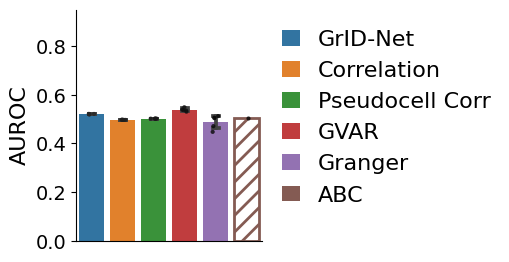

In [21]:
method_list = ['graph.trial{}'.format(trial_no) for trial_no in range(1,6)]
method_list += ['corr.trial{}'.format(trial_no) for trial_no in range(1,6)]
method_list += ['group_corr.trial{}'.format(trial_no) for trial_no in range(1,6)]
method_list += ['gvar.trial{}'.format(trial_no) for trial_no in range(1,6)]
method_list += ['granger.trial{}'.format(trial_no) for trial_no in range(1,6)]
method_list += ['ABC.score']

feature = 'hg38tohg19_eqtl'
direction = 'less'

metric = 'auroc'
results_df = print_results(eval_df_eqtl,method_list,feature,eqtl_lower_thresh,direction,metric=metric)

results_df['method'] = [convert_name(n) for n in results_df['method']]

plt.figure(figsize=(len(set(results_df['method']))/2.5,3))
ax = create_plot(results_df,metric)
plt.rcParams['hatch.linewidth'] = 2
ax.patches[-1].set_edgecolor(ax.patches[-1]._facecolor)
ax.patches[-1].set_facecolor('white')
ax.patches[-1].set_hatch('//')
ax.patches[-1].set_linewidth(2)
    
# plt.tick_params(
#     axis='x',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     bottom=False,      # ticks along the bottom edge are off
#     top=False,         # ticks along the top edge are off
#     labelbottom=False) # labels along the bottom edge are off
# plt.legend(bbox_to_anchor=(1,1),fontsize=16,frameon=False,handlelength=0.8)
# sns.despine()

plt.ylim([0,0.95])

plot_dir = '/data/cb/alexwu/mm_finemap/figures'
plt.savefig(os.path.join(plot_dir,'auroc','{}.eqtl.0125.pdf'.format(dataset)), dpi=500, bbox_inches = "tight")
results_df.to_csv(os.path.join(plot_dir,'auroc','{}.eqtl.0125.csv'.format(dataset)), index=False)

plt.show()

In [22]:
from scipy.stats import ttest_ind

for method in ["Correlation","Pseudocell Corr","GVAR","Granger"]:
    print(method)
    print(ttest_ind(results_df[results_df["method"] == "GrID-Net"]["auroc"],
          results_df[results_df["method"] == method]["auroc"],
          equal_var=False,alternative='greater'))
    print('------')

Correlation
Ttest_indResult(statistic=42.470570546006414, pvalue=2.276710620207932e-09)
------
Pseudocell Corr
Ttest_indResult(statistic=38.6323837099345, pvalue=1.2869368786018367e-06)
------
GVAR
Ttest_indResult(statistic=-5.684989052418132, pvalue=0.997956949696821)
------
Granger
Ttest_indResult(statistic=2.594739174766271, pvalue=0.030101938993200326)
------


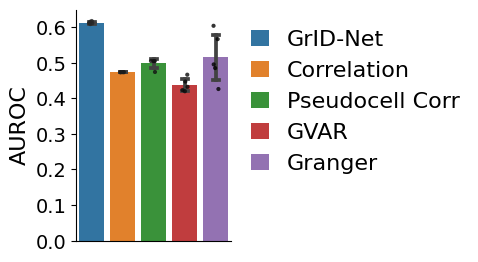

In [23]:
method_list = ['graph.trial{}'.format(trial_no) for trial_no in range(1,6)]
method_list += ['corr.trial{}'.format(trial_no) for trial_no in range(1,6)]
method_list += ['group_corr.trial{}'.format(trial_no) for trial_no in range(1,6)]
method_list += ['gvar.trial{}'.format(trial_no) for trial_no in range(1,6)]
method_list += ['granger.trial{}'.format(trial_no) for trial_no in range(1,6)]
# method_list += ['ABC.score']

feature = 'hic.100kb.rev'
direction = 'less'

metric = 'auroc'
results_df = print_results(eval_df_hic,method_list,feature,hic_lower_thresh,direction,metric=metric)

results_df['method'] = [convert_name(n) for n in results_df['method']]
results_df = results_df[results_df['method'] != 'ABC']

plt.figure(figsize=(len(set(results_df['method']))/2.5,3))
ax = create_plot(results_df,metric)


plt.ylim([0,0.65])

plot_dir = '/data/cb/alexwu/mm_finemap/figures'
plt.savefig(os.path.join(plot_dir,'auroc','{}.hic.0125.pdf'.format(dataset)), dpi=500, bbox_inches = "tight")
results_df.to_csv(os.path.join(plot_dir,'auroc','{}.hic.0125.csv'.format(dataset)), index=False)

plt.show()

In [24]:
from scipy.stats import ttest_ind

for method in ["Correlation","Pseudocell Corr","GVAR","Granger"]:
    print(method)
    print(ttest_ind(results_df[results_df["method"] == "GrID-Net"]["auroc"],
          results_df[results_df["method"] == method]["auroc"],
          equal_var=False,alternative='greater'))
    print('------')

Correlation
Ttest_indResult(statistic=89.15985060753238, pvalue=4.383028537590831e-08)
------
Pseudocell Corr
Ttest_indResult(statistic=17.97787585774032, pvalue=1.1303491611777168e-05)
------
GVAR
Ttest_indResult(statistic=20.07466897109925, pvalue=1.0980349724136479e-05)
------
Granger
Ttest_indResult(statistic=3.0947046891717287, pvalue=0.018084044227289903)
------


### Intersection of eQTL & Hi-C

In [25]:
eqtl_feature = 'hg38tohg19_eqtl'
eqtl_lower_thresh = 1e-10
eval_df_eqtl = eval_df[~np.isnan(eval_df[eqtl_feature])].copy()

# FDR correction
from statsmodels.stats.multitest import fdrcorrection
eval_df_eqtl['eqtl.q'] = fdrcorrection(eval_df_eqtl[eqtl_feature])[1]

# eval_df_eqtl = distance_matched_df(eval_df_eqtl,'eqtl.q',eqtl_lower_thresh,negpos_ratio=1,seed=1)

eval_df_hic = eval_df[~np.isnan(eval_df['hic.100kb'])].copy()
eval_df_hic = eval_df_hic[eval_df_hic['hic.100kb'] != 0]
eval_df_hic['hic.100kb.rev'] = -eval_df_hic['hic.100kb'].values
# eval_df_hic = eval_df_hic[abs(eval_df_hic['dist']) > 50000]
hic_lower_thresh = -np.percentile(eval_df_hic['hic.100kb'],95)

# eval_df_hic = distance_matched_df(eval_df_hic,'hic.100kb.rev',hic_lower_thresh,negpos_ratio=1,seed=1,dist_min=5)

In [26]:
idx2keep = list(set(eval_df_hic.index.values) & set(eval_df_eqtl.index.values))

eval_df_eqtl_hic = eval_df_hic.loc[idx2keep]
eval_df_eqtl_hic["eqtl_hic_thresh"] = ((eval_df_eqtl_hic["hic.100kb.rev"] < hic_lower_thresh) & (eval_df_eqtl_hic[eqtl_feature] < eqtl_lower_thresh)).astype(float)

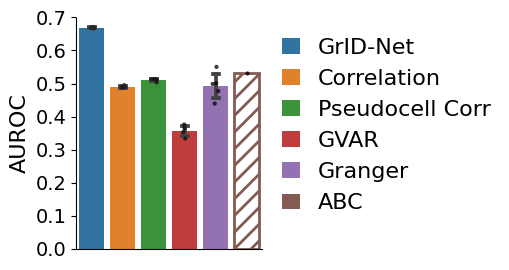

In [27]:
method_list = ['graph.trial{}'.format(trial_no) for trial_no in range(1,6)] + \
                ['corr.trial{}'.format(trial_no) for trial_no in range(1,6)] + \
                ['group_corr.trial{}'.format(trial_no) for trial_no in range(1,6)]
method_list += ['gvar.trial{}'.format(trial_no) for trial_no in range(2,6)]
method_list += ['granger.trial{}'.format(trial_no) for trial_no in range(1,6)]
method_list += ['ABC.score']

feature = 'eqtl_hic_thresh'
direction = 'greater'

metric = 'auroc'
results_df = print_results(eval_df_eqtl_hic,method_list,feature,0.5,direction,metric=metric)

results_df['method'] = [convert_name(n) for n in results_df['method']]

# results_df = results_df[results_df['method'] != 'ABC']

plt.figure(figsize=(len(set(results_df['method']))/2.5,3))
ax = create_plot(results_df,metric)
plt.rcParams['hatch.linewidth'] = 2
ax.patches[-1].set_edgecolor(ax.patches[-1]._facecolor)
ax.patches[-1].set_facecolor('white')
ax.patches[-1].set_hatch('//')
ax.patches[-1].set_linewidth(2)

plt.ylim([0,0.7])

plot_dir = '/data/cb/alexwu/mm_finemap/figures'
plt.savefig(os.path.join(plot_dir,'auroc','{}.eqtl_hic_intersection.0125.pdf'.format(dataset)), dpi=500, bbox_inches = "tight")
results_df.to_csv(os.path.join(plot_dir,'auroc','{}.eqtl_hic_intersection.0125.csv'.format(dataset)), index=False)
plt.show()

In [28]:
from scipy.stats import ttest_ind

for method in ["Correlation","Pseudocell Corr","GVAR","Granger"]:
    print(method)
    print(ttest_ind(results_df[results_df["method"] == "GrID-Net"]["auroc"],
          results_df[results_df["method"] == method]["auroc"],
          equal_var=False,alternative='greater'))
    print('------')

Correlation
Ttest_indResult(statistic=113.19538929130721, pvalue=4.301080225498917e-12)
------
Pseudocell Corr
Ttest_indResult(statistic=75.09776510656026, pvalue=1.6848473245260119e-09)
------
GVAR
Ttest_indResult(statistic=33.9357917912583, pvalue=2.5034762478980475e-05)
------
Granger
Ttest_indResult(statistic=9.70671210738785, pvalue=0.00030945436609295133)
------


### eQTL (1e-3)

In [29]:
eqtl_feature = 'hg38tohg19_eqtl'
eqtl_lower_thresh = 1e-3
eval_df_eqtl = eval_df[~np.isnan(eval_df[eqtl_feature])].copy()

# FDR correction
from statsmodels.stats.multitest import fdrcorrection
eval_df_eqtl['eqtl.q'] = fdrcorrection(eval_df_eqtl[eqtl_feature])[1]

eval_df_eqtl = distance_matched_df(eval_df_eqtl,'eqtl.q',eqtl_lower_thresh,negpos_ratio=1,seed=1)

eval_df_hic = eval_df[~np.isnan(eval_df['hic.100kb'])].copy()
eval_df_hic = eval_df_hic[eval_df_hic['hic.100kb'] != 0]
eval_df_hic['hic.100kb.rev'] = -eval_df_hic['hic.100kb'].values
# eval_df_hic = eval_df_hic[abs(eval_df_hic['dist']) > 50000]
hic_lower_thresh = -np.percentile(eval_df_hic['hic.100kb'],99)

eval_df_hic = distance_matched_df(eval_df_hic,'hic.100kb.rev',hic_lower_thresh,negpos_ratio=1,seed=1,dist_min=5)

2 1349 1349
3 516 516
4 2047 2047
5 1157 1157
5 936 936


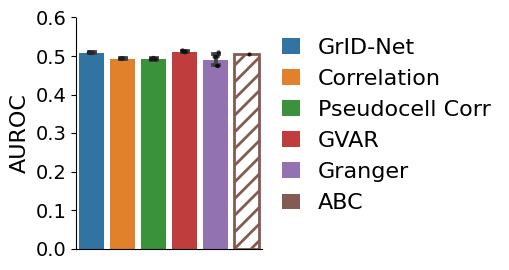

In [30]:
method_list = ['graph.trial{}'.format(trial_no) for trial_no in range(1,6)]
method_list += ['corr.trial{}'.format(trial_no) for trial_no in range(1,6)]
method_list += ['group_corr.trial{}'.format(trial_no) for trial_no in range(1,6)]
method_list += ['gvar.trial{}'.format(trial_no) for trial_no in range(1,6)]
method_list += ['granger.trial{}'.format(trial_no) for trial_no in range(1,6)]
method_list += ['ABC.score']

feature = 'hg38tohg19_eqtl'
direction = 'less'

metric = 'auroc'
results_df = print_results(eval_df_eqtl,method_list,feature,eqtl_lower_thresh,direction,metric=metric)

results_df['method'] = [convert_name(n) for n in results_df['method']]

plt.figure(figsize=(len(set(results_df['method']))/2.5,3))
ax = create_plot(results_df,metric)
plt.rcParams['hatch.linewidth'] = 2
ax.patches[-1].set_edgecolor(ax.patches[-1]._facecolor)
ax.patches[-1].set_facecolor('white')
ax.patches[-1].set_hatch('//')
ax.patches[-1].set_linewidth(2)


plt.ylim([0,0.6])

plot_dir = '/data/cb/alexwu/mm_finemap/figures'
plt.savefig(os.path.join(plot_dir,'auroc','{}.eqtl.1e-3.0125.pdf'.format(dataset)), dpi=500, bbox_inches = "tight")
results_df.to_csv(os.path.join(plot_dir,'auroc','{}.eqtl.1e-3.0125.csv'.format(dataset)), index=False)
plt.show()

In [31]:
from scipy.stats import ttest_ind

for method in ["Correlation","Pseudocell Corr","GVAR","Granger"]:
    print(method)
    print(ttest_ind(results_df[results_df["method"] == "GrID-Net"]["auroc"],
          results_df[results_df["method"] == method]["auroc"],
          equal_var=False,alternative='greater'))
    print('------')

Correlation
Ttest_indResult(statistic=32.771366176825715, pvalue=5.099160068586923e-07)
------
Pseudocell Corr
Ttest_indResult(statistic=18.67974125412761, pvalue=3.6229895561044953e-07)
------
GVAR
Ttest_indResult(statistic=-3.309106926412718, pvalue=0.992407852563805)
------
Granger
Ttest_indResult(statistic=2.5094392935292866, pvalue=0.03280467868333793)
------


### Robustness
#### Highly Variable Genes

In [32]:
n_layers = 10
n_neighbors = 15

method = 'graph'
for trial_no in range(1,6):

    data_dir = '/data/cb/alexwu/mm_finemap/results/tests_nn/{}_{}'.format(dataset,trial_no)

    if dataset == 'human_cortex_multiome_lineage':
        file_name = 'graph.uniform.250kb.trial{}.all.max_scale.mseloss.{}layers.nn{}.statistics.txt'.format(trial_no,n_layers,n_neighbors)
    elif dataset == 'share_seq_more':
        file_name = 'graph.uniform.trial{}.all.max_scale.mseloss.{}layers.nn{}.statistics.txt'.format(trial_no,n_layers,n_neighbors)
    else:
        file_name = 'graph.uniform.1Mb.hv4000.trial{}.all.max_scale.mseloss.{}layers.nn{}.statistics.txt'.format(trial_no,n_layers,n_neighbors)

    scores = pd.read_csv(os.path.join(data_dir,file_name),sep='\t').values[:,2].astype(float)
    scores[np.isinf(scores)] = 10**10
    eval_df['{}.hv4000.trial{}'.format(method,trial_no)] = scores

#### Number of Neighbors

In [33]:
n_layers = 10

method = 'graph'
for trial_no in range(1,6):

    for n_neighbors in [5,25]:
#         if trial_no == 1:
#             data_dir = '/data/cb/alexwu/mm_finemap/results/tests_nn/{}'.format(dataset)
#         else:
        data_dir = '/data/cb/alexwu/mm_finemap/results/tests_nn/{}_{}'.format(dataset,trial_no)

        if dataset == 'human_cortex_multiome_lineage':
            file_name = 'graph.uniform.250kb.trial{}.all.max_scale.mseloss.{}layers.nn{}.statistics.txt'.format(trial_no,n_layers,n_neighbors)
        elif dataset == 'share_seq_more':
            file_name = 'graph.uniform.trial{}.all.max_scale.mseloss.{}layers.nn{}.statistics.txt'.format(trial_no,n_layers,n_neighbors)
        else:
            file_name = 'graph.uniform.1Mb.trial{}.all.max_scale.mseloss.{}layers.nn{}.statistics.txt'.format(trial_no,n_layers,n_neighbors)

        scores = pd.read_csv(os.path.join(data_dir,file_name),sep='\t').values[:,2].astype(float)
        scores[np.isinf(scores)] = 10**10
        eval_df['{}.nn{}.trial{}'.format(method,n_neighbors,trial_no)] = scores

#### Plots

In [34]:
eqtl_feature = 'hg38tohg19_eqtl'
eqtl_lower_thresh = 1e-10
eval_df_eqtl = eval_df[~np.isnan(eval_df[eqtl_feature])].copy()

# FDR correction
from statsmodels.stats.multitest import fdrcorrection
eval_df_eqtl['eqtl.q'] = fdrcorrection(eval_df_eqtl[eqtl_feature])[1]

eval_df_eqtl = distance_matched_df(eval_df_eqtl,'eqtl.q',eqtl_lower_thresh,negpos_ratio=1,seed=1)

eval_df_hic = eval_df[~np.isnan(eval_df['hic.100kb'])].copy()
eval_df_hic = eval_df_hic[eval_df_hic['hic.100kb'] != 0]
eval_df_hic['hic.100kb.rev'] = -eval_df_hic['hic.100kb'].values
# eval_df_hic = eval_df_hic[abs(eval_df_hic['dist']) > 50000]
hic_lower_thresh = -np.percentile(eval_df_hic['hic.100kb'],99)

eval_df_hic = distance_matched_df(eval_df_hic,'hic.100kb.rev',hic_lower_thresh,negpos_ratio=1,seed=1,dist_min=5)

2 500 500
3 183 183
4 627 627
5 249 249
5 936 936


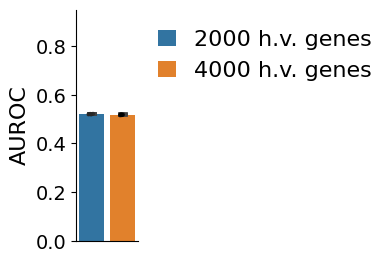

In [35]:
method_list = ['graph.trial{}'.format(trial_no) for trial_no in range(1,6)]
method_list += ['graph.hv4000.trial{}'.format(trial_no) for trial_no in range(1,6)]

feature = 'hg38tohg19_eqtl'
direction = 'less'

metric = 'auroc'
results_df = print_results(eval_df_eqtl,method_list,feature,eqtl_lower_thresh,direction,metric=metric)

results_df['method'] = ["2000 h.v. genes" if "hv" not in n else "4000 h.v. genes" for n in results_df['method']] # [convert_name(n) for n in results_df['method']]

plt.figure(figsize=(len(set(results_df['method']))/2.5,3))
ax = create_plot(results_df,metric)
    
# plt.tick_params(
#     axis='x',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     bottom=False,      # ticks along the bottom edge are off
#     top=False,         # ticks along the top edge are off
#     labelbottom=False) # labels along the bottom edge are off
# plt.legend(bbox_to_anchor=(1,1),fontsize=16,frameon=False,handlelength=0.8)
# sns.despine()

plt.ylim([0,0.95])

plot_dir = '/data/cb/alexwu/mm_finemap/figures'
plt.savefig(os.path.join(plot_dir,'auroc','{}.robustness.hv_genes.eqtl.0125.pdf'.format(dataset)), dpi=500, bbox_inches = "tight")
results_df.to_csv(os.path.join(plot_dir,'auroc','{}.robustness.hv_genes.eqtl.0125.csv'.format(dataset)), index=False)
plt.show()

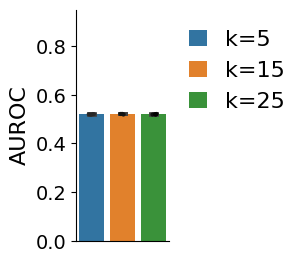

In [36]:
method_list = ['graph.nn5.trial{}'.format(trial_no) for trial_no in range(1,6)]
method_list += ['graph.trial{}'.format(trial_no) for trial_no in range(1,6)]
method_list += ['graph.nn25.trial{}'.format(trial_no) for trial_no in range(1,6)]

feature = 'hg38tohg19_eqtl'
direction = 'less'

metric = 'auroc'
results_df = print_results(eval_df_eqtl,method_list,feature,eqtl_lower_thresh,direction,metric=metric)

results_df['method'] = ["k={}".format(n.split(".nn")[1]) if "nn" in n else "k=15" 
                        for n in results_df['method']]

plt.figure(figsize=(len(set(results_df['method']))/2.5,3))
ax = create_plot(results_df,metric)

plt.ylim([0,0.95])

plot_dir = '/data/cb/alexwu/mm_finemap/figures'
plt.savefig(os.path.join(plot_dir,'auroc','{}.robustness.n_neighbors.eqtl.0125.pdf'.format(dataset)), dpi=500, bbox_inches = "tight")
results_df.to_csv(os.path.join(plot_dir,'auroc','{}.robustness.n_neighbors.eqtl.0125.csv'.format(dataset)), index=False)
plt.show()

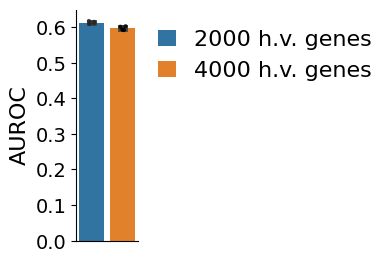

In [37]:
method_list = ['graph.trial{}'.format(trial_no) for trial_no in range(1,6)]
method_list += ['graph.hv4000.trial{}'.format(trial_no) for trial_no in range(1,6)]

feature = 'hic.100kb.rev'
direction = 'less'

metric = 'auroc'
results_df = print_results(eval_df_hic,method_list,feature,hic_lower_thresh,direction,metric=metric)

results_df['method'] = ["2000 h.v. genes" if "hv" not in n else "4000 h.v. genes" for n in results_df['method']] # [convert_name(n) for n in results_df['method']]

results_df = results_df[results_df['method'] != 'ABC']

plt.figure(figsize=(len(set(results_df['method']))/2.5,3))
ax = create_plot(results_df,metric)
    
plt.ylim([0,0.65])

plot_dir = '/data/cb/alexwu/mm_finemap/figures'
plt.savefig(os.path.join(plot_dir,'auroc','{}.robustness.hv_genes.hic.0125.pdf'.format(dataset)), dpi=500, bbox_inches = "tight")
results_df.to_csv(os.path.join(plot_dir,'auroc','{}.robustness.hv_genes.hic.0125.csv'.format(dataset)), index=False)
plt.show()

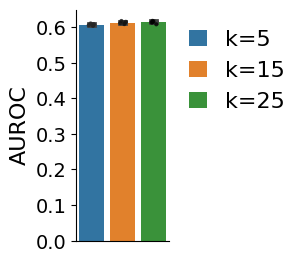

In [38]:
method_list = ['graph.nn5.trial{}'.format(trial_no) for trial_no in range(1,6)]
method_list += ['graph.trial{}'.format(trial_no) for trial_no in range(1,6)]
method_list += ['graph.nn25.trial{}'.format(trial_no) for trial_no in range(1,6)]

feature = 'hic.100kb.rev'
direction = 'less'

metric = 'auroc'
results_df = print_results(eval_df_hic,method_list,feature,hic_lower_thresh,direction,metric=metric)

results_df['method'] = ["k={}".format(n.split(".nn")[1]) if "nn" in n else "k=15" 
                        for n in results_df['method']]

results_df = results_df[results_df['method'] != 'ABC']

plt.figure(figsize=(len(set(results_df['method']))/2.5,3))
ax = create_plot(results_df,metric)

plt.ylim([0,0.65])

plot_dir = '/data/cb/alexwu/mm_finemap/figures'
plt.savefig(os.path.join(plot_dir,'auroc','{}.robustness.n_neighbors.hic.0125.pdf'.format(dataset)), dpi=500, bbox_inches = "tight")
results_df.to_csv(os.path.join(plot_dir,'auroc','{}.robustness.n_neighbors.hic.0125.csv'.format(dataset)), index=False)
plt.show()

### SNARE-seq

In [39]:
name_dict = {'graph': 'GrID-Net',
             'corr': 'Correlation',
             'group_corr': 'Pseudocell Corr',
             'ABC.score': 'ABC'}

In [40]:
dataset = 'snare_seq'

distance = 1000000
gene_percent_cells = 0.01
peak_percent_cells = 0.001

rna_adata,atac_adata,eval_df = load_data(dataset,gene_percent_cells=gene_percent_cells,
                                          peak_percent_cells=peak_percent_cells,
                                          include_h5=True,sampling=None,distance=distance)

eval_df = load_results(dataset,eval_df,ensemble=True)
eval_df['abs_dist'] = abs(eval_df['dist'])

<KeysViewHDF5 ['ABC.score', 'atac_id', 'chr_no', 'corr', 'corr_bin', 'dist', 'eqtl.all', 'eqtl.q', 'gene', 'gene_percent_cells', 'group_corr', 'group_corr_bin', 'hic', 'hic.raw', 'peak_percent_cells']>


In [41]:
# load standard Granger + GVAR results
data_dir = "/data/cb/alexwu/mm_finemap/results/tests_nn"

dataset = 'snare_seq'

# Granger
for trial_no in range(1,6):
    df = pd.read_csv(os.path.join(data_dir,"{}_{}".format(dataset,trial_no),"{}_{}.standard_granger.csv".format(dataset,trial_no)))
    eval_df["granger.trial{}".format(trial_no)] = -np.log10(df["granger_p"].values)
    eval_df["granger.trial{}".format(trial_no)] = eval_df["granger.trial{}".format(trial_no)].replace(np.nan,0)

# GVAR
for trial_no in range(1,6):
    df = pd.read_csv(os.path.join(data_dir,"{}_{}".format(dataset,trial_no),"{}_{}.GVAR.csv".format(dataset,trial_no)))
    p = [float(n.strip("[]")) for n in df["granger_p"].values]
    eval_df["gvar.trial{}".format(trial_no)] = -np.log10(p)

In [42]:
eqtl_feature = 'eqtl.all'
eqtl_lower_thresh = 1e-10
eval_df_eqtl = eval_df[~np.isnan(eval_df[eqtl_feature])].copy()

# FDR correction
from statsmodels.stats.multitest import fdrcorrection
eval_df_eqtl['eqtl.q'] = fdrcorrection(eval_df_eqtl[eqtl_feature])[1]

eval_df_eqtl = distance_matched_df(eval_df_eqtl,'eqtl.q',eqtl_lower_thresh,negpos_ratio=1,seed=1)

eval_df_hic = eval_df[~np.isnan(eval_df['hic'])].copy()
hic_lower_thresh = -np.percentile(eval_df_hic['hic'],99)
# eval_df_hic = eval_df_hic[abs(eval_df_hic['dist']) > 50000].copy()

eval_df_hic = eval_df_hic[eval_df_hic['hic'] != 0].copy()
eval_df_hic['hic.rev'] = -eval_df_hic['hic'].values

eval_df_hic = distance_matched_df(eval_df_hic,'hic.rev',hic_lower_thresh,negpos_ratio=1,seed=1,dist_min=5)

2 1 1
3 1 1
4 3 3
5 2 2
5 2017 2017


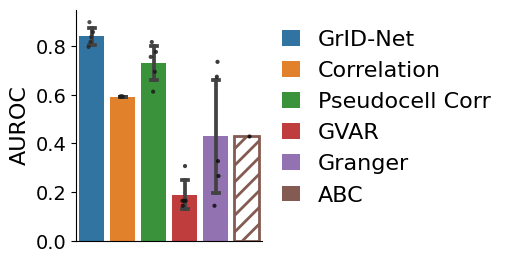

In [43]:
method_list = ['graph.trial{}'.format(trial_no) for trial_no in range(1,6)]
method_list += ['corr.trial{}'.format(trial_no) for trial_no in range(1,6)]
method_list += ['group_corr.trial{}'.format(trial_no) for trial_no in range(1,6)]
method_list += ['gvar.trial{}'.format(trial_no) for trial_no in range(1,6)]
method_list += ['granger.trial{}'.format(trial_no) for trial_no in range(1,6)]
method_list += ['ABC.score']

feature = 'eqtl.all'
direction = 'less'

metric = 'auroc'
results_df = print_results(eval_df_eqtl,method_list,feature,eqtl_lower_thresh,direction,metric=metric)
results_df['method'] = [convert_name(n) for n in results_df['method']]

plt.figure(figsize=(len(set(results_df['method']))/2.5,3))
ax = create_plot(results_df,metric)
plt.rcParams['hatch.linewidth'] = 2
ax.patches[-1].set_edgecolor(ax.patches[-1]._facecolor)
ax.patches[-1].set_facecolor('white')
ax.patches[-1].set_hatch('//')
ax.patches[-1].set_linewidth(2)

plt.ylim([0,0.95])

plot_dir = '/data/cb/alexwu/mm_finemap/figures'
plt.savefig(os.path.join(plot_dir,'auroc','{}.eqtl.0125.pdf'.format(dataset)), dpi=500, bbox_inches = "tight")
results_df.to_csv(os.path.join(plot_dir,'auroc','{}.eqtl.0125.csv'.format(dataset)), index=False)

plt.show()

In [44]:
from scipy.stats import ttest_ind

for method in ["Correlation","Pseudocell Corr","GVAR","Granger"]:
    print(method)
    print(ttest_ind(results_df[results_df["method"] == "GrID-Net"]["auroc"],
          results_df[results_df["method"] == method]["auroc"],
          equal_var=False,alternative='greater'))
    print('------')

Correlation
Ttest_indResult(statistic=14.182211926745955, pvalue=7.176059019144575e-05)
------
Pseudocell Corr
Ttest_indResult(statistic=2.777460299317654, pvalue=0.016520007856796082)
------
GVAR
Ttest_indResult(statistic=18.85618083164127, pvalue=3.3640335738344607e-07)
------
Granger
Ttest_indResult(statistic=3.4931580425236772, pvalue=0.01165698769480839)
------


/tmp/ipykernel_1790568/1288374285.py:5: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  print(ttest_ind(results_df[results_df["method"] == "GrID-Net"]["auroc"],


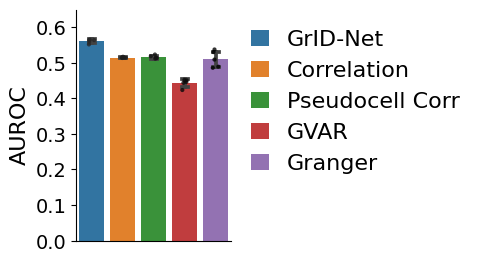

In [45]:
method_list = ['graph.trial{}'.format(trial_no) for trial_no in range(1,6)]
method_list += ['corr.trial{}'.format(trial_no) for trial_no in range(1,6)]
method_list += ['group_corr.trial{}'.format(trial_no) for trial_no in range(1,6)]
method_list += ['gvar.trial{}'.format(trial_no) for trial_no in range(1,6)]
method_list += ['granger.trial{}'.format(trial_no) for trial_no in range(1,6)]
# method_list += ['ABC.score']

feature = 'hic.rev'
direction = 'less'

metric = 'auroc'
results_df = print_results(eval_df_hic,method_list,feature,hic_lower_thresh,direction,metric=metric)
results_df['method'] = [convert_name(n) for n in results_df['method']]

results_df = results_df[results_df['method'] != 'ABC']

plt.figure(figsize=(len(set(results_df['method']))/2.5,3))
ax = create_plot(results_df,metric)

plt.ylim([0,0.65])

plot_dir = '/data/cb/alexwu/mm_finemap/figures'
plt.savefig(os.path.join(plot_dir,'auroc','{}.hic.0125.pdf'.format(dataset)), dpi=500, bbox_inches = "tight")
results_df.to_csv(os.path.join(plot_dir,'auroc','{}.hic.0125.csv'.format(dataset)), index=False)

plt.show()

In [46]:
from scipy.stats import ttest_ind

for method in ["Correlation","Pseudocell Corr","GVAR","Granger"]:
    print(method)
    print(ttest_ind(results_df[results_df["method"] == "GrID-Net"]["auroc"],
          results_df[results_df["method"] == method]["auroc"],
          equal_var=False,alternative='greater'))
    print('------')

Correlation
Ttest_indResult(statistic=17.824872139466837, pvalue=1.341746718385805e-05)
------
Pseudocell Corr
Ttest_indResult(statistic=13.64969684134011, pvalue=5.501011560799633e-07)
------
GVAR
Ttest_indResult(statistic=20.558595626364056, pvalue=5.847289894041965e-07)
------
Granger
Ttest_indResult(statistic=4.721324773801328, pvalue=0.0034843537609267916)
------


### Intersection of eQTL + Hi-C

In [47]:
eqtl_feature = 'eqtl.all'
eqtl_lower_thresh = 1e-10
eval_df_eqtl = eval_df[~np.isnan(eval_df[eqtl_feature])].copy()

# FDR correction
from statsmodels.stats.multitest import fdrcorrection
eval_df_eqtl['eqtl.q'] = fdrcorrection(eval_df_eqtl[eqtl_feature])[1]

# eval_df_eqtl = distance_matched_df(eval_df_eqtl,'eqtl.q',eqtl_lower_thresh,negpos_ratio=1,seed=1)

eval_df_hic = eval_df[~np.isnan(eval_df['hic'])].copy()
hic_lower_thresh = -np.percentile(eval_df_hic['hic'],95)
# eval_df_hic = eval_df_hic[abs(eval_df_hic['dist']) > 50000].copy()

eval_df_hic = eval_df_hic[eval_df_hic['hic'] != 0].copy()
eval_df_hic['hic.rev'] = -eval_df_hic['hic'].values

# eval_df_hic = distance_matched_df(eval_df_hic,'hic.rev',hic_lower_thresh,negpos_ratio=1,seed=1,dist_min=5)

In [48]:
idx2keep = list(set(eval_df_hic.index.values) & set(eval_df_eqtl.index.values))

eval_df_eqtl_hic = eval_df_hic.loc[idx2keep]
eval_df_eqtl_hic["eqtl_hic_thresh"] = ((eval_df_eqtl_hic["hic.rev"] < hic_lower_thresh) & (eval_df_eqtl_hic[eqtl_feature] < eqtl_lower_thresh)).astype(float)

In [49]:
eval_df_eqtl_hic["eqtl_hic_thresh"].sum()

0.0

### eQTL (1e-3)

In [50]:
eqtl_feature = 'eqtl.all'
eqtl_lower_thresh = 1e-3
eval_df_eqtl = eval_df[~np.isnan(eval_df[eqtl_feature])].copy()

# FDR correction
from statsmodels.stats.multitest import fdrcorrection
eval_df_eqtl['eqtl.q'] = fdrcorrection(eval_df_eqtl[eqtl_feature])[1]

eval_df_eqtl = distance_matched_df(eval_df_eqtl,'eqtl.q',eqtl_lower_thresh,negpos_ratio=1,seed=1)

eval_df_hic = eval_df[~np.isnan(eval_df['hic'])].copy()
hic_lower_thresh = -np.percentile(eval_df_hic['hic'],99)
# eval_df_hic = eval_df_hic[abs(eval_df_hic['dist']) > 50000].copy()

eval_df_hic = eval_df_hic[eval_df_hic['hic'] != 0].copy()
eval_df_hic['hic.rev'] = -eval_df_hic['hic'].values

eval_df_hic = distance_matched_df(eval_df_hic,'hic.rev',hic_lower_thresh,negpos_ratio=1,seed=1,dist_min=5)

2 8 8
3 5 5
4 19 19
5 7 7
5 2017 2017


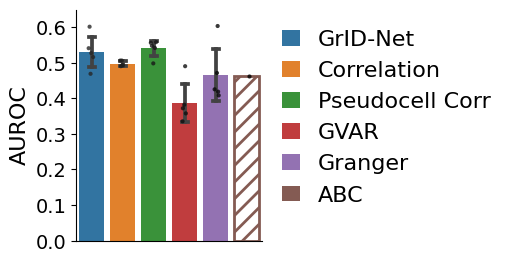

In [51]:
method_list = ['graph.trial{}'.format(trial_no) for trial_no in range(1,6)]
method_list += ['corr.trial{}'.format(trial_no) for trial_no in range(1,6)]
method_list += ['group_corr.trial{}'.format(trial_no) for trial_no in range(1,6)]
method_list += ['gvar.trial{}'.format(trial_no) for trial_no in range(1,6)]
method_list += ['granger.trial{}'.format(trial_no) for trial_no in range(1,6)]
method_list += ['ABC.score']

feature = 'eqtl.all'
direction = 'less'

metric = 'auroc'
results_df = print_results(eval_df_eqtl,method_list,feature,eqtl_lower_thresh,direction,metric=metric)
results_df['method'] = [convert_name(n) for n in results_df['method']]

plt.figure(figsize=(len(set(results_df['method']))/2.5,3))
ax = create_plot(results_df,metric)
plt.rcParams['hatch.linewidth'] = 2
ax.patches[-1].set_edgecolor(ax.patches[-1]._facecolor)
ax.patches[-1].set_facecolor('white')
ax.patches[-1].set_hatch('//')
ax.patches[-1].set_linewidth(2)
    
# plt.tick_params(
#     axis='x',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     bottom=False,      # ticks along the bottom edge are off
#     top=False,         # ticks along the top edge are off
#     labelbottom=False) # labels along the bottom edge are off
# plt.legend(bbox_to_anchor=(1,1),fontsize=16,frameon=False,handlelength=0.8)
# sns.despine()

plt.ylim([0,0.65])

plot_dir = '/data/cb/alexwu/mm_finemap/figures'
plt.savefig(os.path.join(plot_dir,'auroc','{}.eqtl.1e-3.0125.pdf'.format(dataset)), dpi=500, bbox_inches = "tight")
results_df.to_csv(os.path.join(plot_dir,'auroc','{}.eqtl.1e-3.0125.csv'.format(dataset)), index=False)

plt.show()

In [52]:
from scipy.stats import ttest_ind

for method in ["Correlation","Pseudocell Corr","GVAR","Granger"]:
    print(method)
    print(ttest_ind(results_df[results_df["method"] == "GrID-Net"]["auroc"],
          results_df[results_df["method"] == method]["auroc"],
          equal_var=False,alternative='greater'))
    print('------')

Correlation
Ttest_indResult(statistic=1.5322177400763743, pvalue=0.09836332197526997)
------
Pseudocell Corr
Ttest_indResult(statistic=-0.39141521152027264, pvalue=0.645444163801075)
------
GVAR
Ttest_indResult(statistic=4.175133495228332, pvalue=0.0017295339010215747)
------
Granger
Ttest_indResult(statistic=1.5600918382314908, pvalue=0.08300774371141492)
------


### Robustness
#### Highly Variable Genes

In [53]:
n_layers = 10
n_neighbors = 15

method = 'graph'
for trial_no in range(1,6):

    data_dir = '/data/cb/alexwu/mm_finemap/results/tests_nn/{}_{}'.format(dataset,trial_no)

    if dataset == 'human_cortex_multiome_lineage':
        file_name = 'graph.uniform.250kb.trial{}.all.max_scale.mseloss.{}layers.nn{}.statistics.txt'.format(trial_no,n_layers,n_neighbors)
    elif dataset == 'share_seq_more':
        file_name = 'graph.uniform.trial{}.all.max_scale.mseloss.{}layers.nn{}.statistics.txt'.format(trial_no,n_layers,n_neighbors)
    else:
        file_name = 'graph.uniform.1Mb.hv4000.trial{}.all.max_scale.mseloss.{}layers.nn{}.statistics.txt'.format(trial_no,n_layers,n_neighbors)

    scores = pd.read_csv(os.path.join(data_dir,file_name),sep='\t').values[:,2].astype(float)
    scores[np.isinf(scores)] = 10**10
    eval_df['{}.hv4000.trial{}'.format(method,trial_no)] = scores

#### Number of Neighbors

In [54]:
n_layers = 10

method = 'graph'
for trial_no in range(1,6):

    for n_neighbors in [5,25]:
#         if trial_no == 1:
#             data_dir = '/data/cb/alexwu/mm_finemap/results/tests_nn/{}'.format(dataset)
#         else:
        data_dir = '/data/cb/alexwu/mm_finemap/results/tests_nn/{}_{}'.format(dataset,trial_no)

        if dataset == 'human_cortex_multiome_lineage':
            file_name = 'graph.uniform.250kb.trial{}.all.max_scale.mseloss.{}layers.nn{}.statistics.txt'.format(trial_no,n_layers,n_neighbors)
        elif dataset == 'share_seq_more':
            file_name = 'graph.uniform.trial{}.all.max_scale.mseloss.{}layers.nn{}.statistics.txt'.format(trial_no,n_layers,n_neighbors)
        else:
            file_name = 'graph.uniform.1Mb.trial{}.all.max_scale.mseloss.{}layers.nn{}.statistics.txt'.format(trial_no,n_layers,n_neighbors)

        scores = pd.read_csv(os.path.join(data_dir,file_name),sep='\t').values[:,2].astype(float)
        scores[np.isinf(scores)] = 10**10
        eval_df['{}.nn{}.trial{}'.format(method,n_neighbors,trial_no)] = scores

#### Plots

In [55]:
eqtl_feature = 'eqtl.all'
eqtl_lower_thresh = 1e-10
eval_df_eqtl = eval_df[~np.isnan(eval_df[eqtl_feature])].copy()

# FDR correction
from statsmodels.stats.multitest import fdrcorrection
eval_df_eqtl['eqtl.q'] = fdrcorrection(eval_df_eqtl[eqtl_feature])[1]

eval_df_eqtl = distance_matched_df(eval_df_eqtl,'eqtl.q',eqtl_lower_thresh,negpos_ratio=1,seed=1)

eval_df_hic = eval_df[~np.isnan(eval_df['hic'])].copy()
hic_lower_thresh = -np.percentile(eval_df_hic['hic'],99)
# eval_df_hic = eval_df_hic[abs(eval_df_hic['dist']) > 50000].copy()

eval_df_hic = eval_df_hic[eval_df_hic['hic'] != 0].copy()
eval_df_hic['hic.rev'] = -eval_df_hic['hic'].values

eval_df_hic = distance_matched_df(eval_df_hic,'hic.rev',hic_lower_thresh,negpos_ratio=1,seed=1,dist_min=5)

2 1 1
3 1 1
4 3 3
5 2 2
5 2017 2017


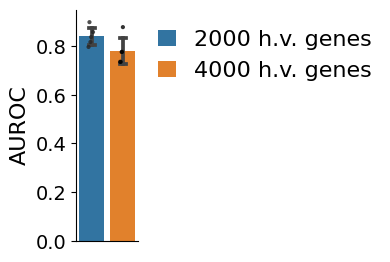

In [56]:
method_list = ['graph.trial{}'.format(trial_no) for trial_no in range(1,6)]
method_list += ['graph.hv4000.trial{}'.format(trial_no) for trial_no in range(1,6)]

feature = 'eqtl.all'
direction = 'less'

metric = 'auroc'
results_df = print_results(eval_df_eqtl,method_list,feature,eqtl_lower_thresh,direction,metric=metric)

results_df['method'] = ["2000 h.v. genes" if "hv" not in n else "4000 h.v. genes" for n in results_df['method']] # [convert_name(n) for n in results_df['method']]

plt.figure(figsize=(len(set(results_df['method']))/2.5,3))
ax = create_plot(results_df,metric)

plt.ylim([0,0.95])

plot_dir = '/data/cb/alexwu/mm_finemap/figures'
plt.savefig(os.path.join(plot_dir,'auroc','{}.robustness.hv_genes.eqtl.0125.pdf'.format(dataset)), dpi=500, bbox_inches = "tight")
results_df.to_csv(os.path.join(plot_dir,'auroc','{}.robustness.hv_genes.eqtl.0125.csv'.format(dataset)), index=False)

plt.show()

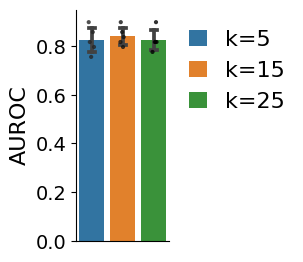

In [57]:
method_list = ['graph.nn5.trial{}'.format(trial_no) for trial_no in range(1,6)]
method_list += ['graph.trial{}'.format(trial_no) for trial_no in range(1,6)]
method_list += ['graph.nn25.trial{}'.format(trial_no) for trial_no in range(1,6)]

feature = 'eqtl.all'
direction = 'less'

metric = 'auroc'
results_df = print_results(eval_df_eqtl,method_list,feature,eqtl_lower_thresh,direction,metric=metric)

results_df['method'] = ["k={}".format(n.split(".nn")[1]) if "nn" in n else "k=15" 
                        for n in results_df['method']]

plt.figure(figsize=(len(set(results_df['method']))/2.5,3))
ax = create_plot(results_df,metric)

plt.ylim([0,0.95])

plot_dir = '/data/cb/alexwu/mm_finemap/figures'
plt.savefig(os.path.join(plot_dir,'auroc','{}.robustness.n_neighbors.eqtl.0125.pdf'.format(dataset)), dpi=500, bbox_inches = "tight")
results_df.to_csv(os.path.join(plot_dir,'auroc','{}.robustness.n_neighbors.eqtl.0125.csv'.format(dataset)), index=False)

plt.show()

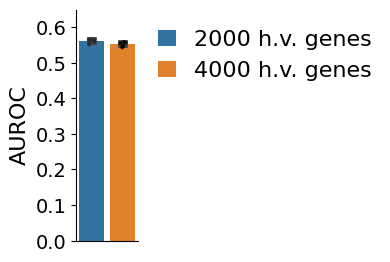

In [58]:
method_list = ['graph.trial{}'.format(trial_no) for trial_no in range(1,6)]
method_list += ['graph.hv4000.trial{}'.format(trial_no) for trial_no in range(1,6)]

feature = 'hic.rev'
direction = 'less'

metric = 'auroc'
results_df = print_results(eval_df_hic,method_list,feature,hic_lower_thresh,direction,metric=metric)

results_df['method'] = ["2000 h.v. genes" if "hv" not in n else "4000 h.v. genes" for n in results_df['method']] # [convert_name(n) for n in results_df['method']]

results_df = results_df[results_df['method'] != 'ABC']

plt.figure(figsize=(len(set(results_df['method']))/2.5,3))
ax = create_plot(results_df,metric)

plt.ylim([0,0.65])

plot_dir = '/data/cb/alexwu/mm_finemap/figures'
plt.savefig(os.path.join(plot_dir,'auroc','{}.robustness.hv_genes.hic.0125.pdf'.format(dataset)), dpi=500, bbox_inches = "tight")
results_df.to_csv(os.path.join(plot_dir,'auroc','{}.robustness.hv_genes.hic.0125.csv'.format(dataset)), index=False)

plt.show()

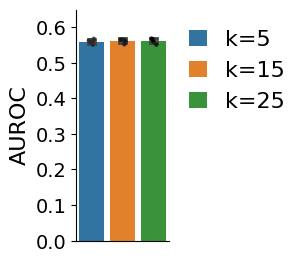

In [59]:
method_list = ['graph.nn5.trial{}'.format(trial_no) for trial_no in range(1,6)]
method_list += ['graph.trial{}'.format(trial_no) for trial_no in range(1,6)]
method_list += ['graph.nn25.trial{}'.format(trial_no) for trial_no in range(1,6)]

feature = 'hic.rev'
direction = 'less'

metric = 'auroc'
results_df = print_results(eval_df_hic,method_list,feature,hic_lower_thresh,direction,metric=metric)

results_df['method'] = ["k={}".format(n.split(".nn")[1]) if "nn" in n else "k=15" 
                        for n in results_df['method']]

results_df = results_df[results_df['method'] != 'ABC']

plt.figure(figsize=(len(set(results_df['method']))/2.5,3))
ax = create_plot(results_df,metric)

plt.ylim([0,0.65])

plot_dir = '/data/cb/alexwu/mm_finemap/figures'
plt.savefig(os.path.join(plot_dir,'auroc','{}.robustness.n_neighbors.hic.0125.pdf'.format(dataset)), dpi=500, bbox_inches = "tight")
results_df.to_csv(os.path.join(plot_dir,'auroc','{}.robustness.n_neighbors.hic.0125.csv'.format(dataset)), index=False)

plt.show()